# Accuracy measurements - STREAM setting

**Requirements**: Pandas, Matplotlib, scienceplots (to style the plots)

In [1]:
DATASET = "fmow" #used: yearbook, fmow, huffpost

OUTPUT_FOLDER = "out_clean"
# PATH3 stores the results of SGS3, PATH4 of SGS4
PATH3 = f"../clean_data/sgs3/stream/{DATASET}/accuracies.json"
PATH4 = f"../clean_data/sgs4/stream/{DATASET}/accuracies.json"
KEEP_INCOMPLETE_MEASUREMENTS = False # "incomplete" = measurements from only one machine

# Yb charts are orange, fmow ones are green and huffpost ones are purple
TITLE_COLOR = "#FC6A49"
if DATASET == "fmow":
    TITLE_COLOR = "#6F9074"
elif DATASET == "huffpost":
    TITLE_COLOR = "#745474"

In [2]:
import json
import pandas as pd
from chart_style_mpl import set_size
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl

## Data loading

Expected format:
List of {"Experiment": "ExperimentName", "Model trigger": 0, "top1": 0.0459, "top3": 0.101, "top5": 0.165}
top1 is the "classic" accuracy (predicted class = real one), top3 and top5 are not used in the charts so can be omitted.

In [3]:
with open(PATH3, "r") as f:
    data3 = json.load(f)
with open(PATH4, "r") as f:
    data4 = json.load(f)

In [4]:
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)

data = df3.merge(df4, on=['Experiment', 'Model trigger'], how='outer', suffixes=('_sgs3', '_sgs4'))
data['average'] = (data['top1_sgs3'] + data['top1_sgs4']) / 2
if not KEEP_INCOMPLETE_MEASUREMENTS:
    data = data.dropna(subset=['top1_sgs3', 'top1_sgs4'])

data = data.rename(columns={'top1_sgs3': 'sgs3', 'top1_sgs4': 'sgs4'})
data = data[['Experiment', 'Model trigger', 'average', 'sgs3', 'sgs4']]

## Chart sets

Experiments are grouped based on the strategy used

In [5]:
groups = {
    "STB": ["Gradnorm_25pc_10ep_reset_STB", "Loss_25pc_10ep_reset_STB", "Craig_25pc_10ep_reset_STB", "GradMatch_25pc_10ep_reset_STB", "SubmodularFL_25pc_10ep_reset_STB", "Margin_25pc_10ep_reset_STB", "Kcenter_25pc_10ep_reset_STB", "SubmodularGC_25pc_10ep_reset_STB", "SubmodularLD_25pc_10ep_reset_STB"],
    "BTS": ["Gradnorm_25pc_10ep_reset", "Loss_25pc_10ep_reset", "Craig_25pc_10ep_reset", "GradMatch_25pc_10ep_reset", "SubmodularFL_25pc_10ep_reset", "Margin_25pc_10ep_reset", "Kcenter_25pc_10ep_reset", "SubmodularGC_25pc_10ep_reset", "SubmodularLD_25pc_10ep_reset"],
    "P_50": ["random_50pc_10ep_reset", "labelBalanced_50pc_10ep_reset"],
    "P_25": ["random_25pc_10ep_reset","labelBalanced_25pc_10ep_reset"],
    "A": ["all_data_2ep_reset", "all_data_5ep_reset", "all_data_10ep_reset"]
}


labels = []
for experiment in data["Experiment"].to_list():
    found = False
    for key in groups:
        if experiment in groups[key]:
            labels.append(key)
            found = True
            break
    if not found:
        labels.append("Extra")
data["group"] = labels

data.sort_values(by="Model trigger", inplace=True)

## Presamplers and all

Expected output:
![presamplers](../demo_out/pres_stream_fmow.png)

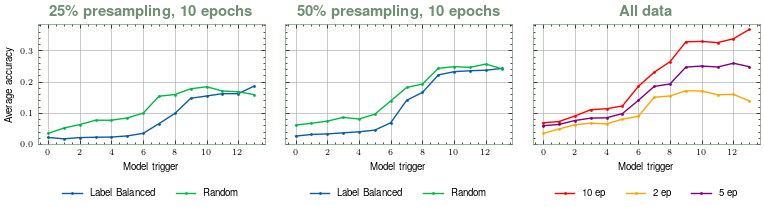

In [6]:
plt.style.use(['science'])
tex_fonts = {
    "text.usetex": True,
    "font.family": "Helvetica",
    "axes.labelsize": 7,
    "font.size": 9,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}
plt.rcParams.update(tex_fonts)
size = set_size(fraction=1.5, subplots=(1.5,3))
size = (size[0], size[1] )
fig, axes = plt.subplots(1, 3, figsize=size, sharey="row")
coordinates = {
    "P_50" : 1,
    "P_25" : 0,
    "A": 2
}
titles = {
    "P_50" : "50\\% presampling, 10 epochs",
    "P_25" : "25\\% presampling, 10 epochs",
    "A": "All data"
}
names = {
    "random": "Random",
    "randomNoRep": "Random without replacement",
    "labelBalanced": "Label Balanced",
    "triggerBalanced": "Trigger Balanced",
    "all_data_5ep_reset": "5 ep",
    "all_data_2ep_reset": "2 ep",
    "all_data_10ep_reset": "10 ep",
    "all_data_5ep_reset_32BS": "5 ep",
    "all_data_2ep_reset_32BS": "2 ep",
    "all_data_10ep_reset_32BS": "10 ep",
}
for group_name in coordinates.keys():

    subplot_position = coordinates[group_name]
    subplot_title = titles[group_name]

    i = 0
    for experiment, group in data.groupby("Experiment"):
        if list(group["group"].unique())[0] == group_name:
            if "P" in group_name:
                axes[subplot_position].plot(group["Model trigger"], group["average"], marker = ".", label=names[experiment.split("_")[0]], markersize = 2)
            else:
                # force different colors for all_data baselines
                color = ["red", "orange", "purple"][i]
                axes[subplot_position].plot(group["Model trigger"], group["average"], label=names[experiment], markersize = 2, marker = ".", color = color)
                i +=1

    # Add labels and legend
    axes[subplot_position].set_xlabel("Model trigger")

    # title
    title = "\\textbf{" + subplot_title + "}"
    axes[subplot_position].set_title(title, color = TITLE_COLOR)

    # color the spines with the proper color
    for spine in ["bottom", "top", "right", "left"]:
        axes[subplot_position].spines[spine].set_color(TITLE_COLOR)

    axes[subplot_position].legend( ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.3), )
    #axes[subplot_position].grid() sometimes it is needed, sometimes is not... who understands mpl...

axes[0].set_ylabel("Average accuracy")
plt.tight_layout()
#legend.get_lines()[0].set_markersize(15)
plt.savefig(f"{OUTPUT_FOLDER}/pres_stream_{DATASET}.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Downsamplers

Expected output:
![downs](../demo_out/downs_stream_fmow.png)

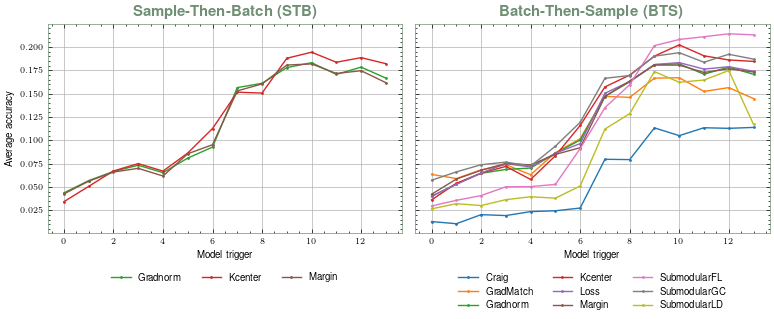

In [7]:
plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

colors = {
    "Craig" : 0,
    "GradMatch": 1,
    "Gradnorm": 2,
    "Kcenter":3,
    "Loss":4,
    "Margin": 5,
    "SubmodularFL": 6,
    "SubmodularGC": 7,
    "SubmodularLD": 8
}
plt.rcParams.update(tex_fonts)
size = set_size(fraction=1.5, subplots=(1,2))
size = (size[0], size[1] + 1)
fig, axes = plt.subplots(1, 2, figsize=size, sharey="row")
coordinates = {
    "STB" : 0,
    "BTS" : 1,
}
titles = {
    "STB" : "Sample-Then-Batch (STB)",
    "BTS" : "Batch-Then-Sample (BTS)",
}
names = {
    "all_data": "1 epoch",
    "all_data_2ep": "2 epochs",
    "all_data_4ep": "4 epochs",
}

tex_fonts = {
    "text.usetex": True,
    "font.family": "Helvetica",
    "axes.labelsize": 7,
    "font.size": 9,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}

for group_name in coordinates.keys():

    subplot_position = coordinates[group_name]
    subplot_title = titles[group_name]
    index = 0
    for experiment, group in data.groupby("Experiment"):
        if list(group["group"].unique())[0] == group_name:
            name = experiment.split("_")[0]
            axes[subplot_position].plot(group["Model trigger"], group["average"], label=name, markersize = 2, marker = ".", color=mpl.colormaps["tab10"](colors[name]))
            index += 1


    # Add labels and legend
    axes[subplot_position].set_xlabel("Model trigger")

    title = "\\textbf{" + subplot_title + "}"
    axes[subplot_position].set_title(title, color = TITLE_COLOR)
    axes[subplot_position].legend( ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15), )
    axes[subplot_position].grid()
    # color the spines with the proper color
    for spine in ["bottom", "top", "right", "left"]:
        axes[subplot_position].spines[spine].set_color(TITLE_COLOR)

axes[0].set_ylabel("Average accuracy")
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/downs_stream_{DATASET}.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Best

Expected output:
![selector_time](../demo_out/best_stream_fmow.png)

In [8]:
categories = ["BTS", "STB", "P_25"]

In [9]:
categ_data = data[data.group.isin(categories)].groupby(["Experiment", "group"]).mean().sort_values("average", ascending=False)
top5 = [el[0] for el in categ_data.index.to_list()][:5]
filtered = data[data.Experiment.isin(top5)]

baselines = data[data.group == "A"]

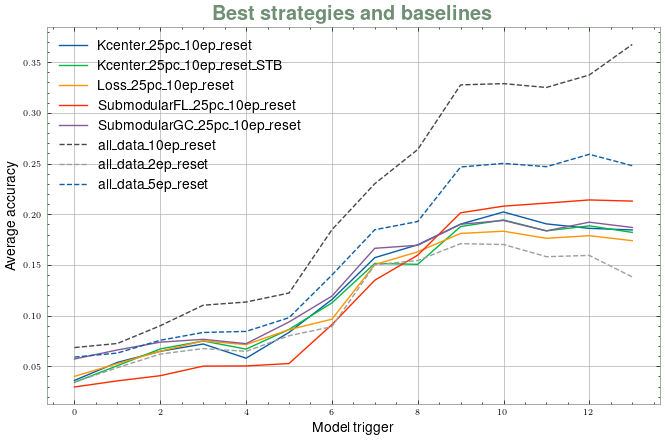

In [10]:
plt.style.use(['science'])
tex_fonts = {
    "text.usetex": True,
    "font.family": "Helvetica",
    "axes.labelsize": 10,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}
plt.rcParams.update(tex_fonts)
fig, ax = plt.subplots(1, 1, figsize=set_size( fraction=1.5))

for experiment, group in filtered.groupby("Experiment"):
    plt.plot(group["Model trigger"], group["average"], label=experiment)

for experiment, group in baselines.groupby("Experiment"):
    plt.plot(group["Model trigger"], group["average"], label=experiment, linestyle="dashed")

plt.xlabel("Model trigger")
plt.ylabel("Average accuracy")
plt.legend(ncol=1)
plt.title(r"\textbf{Best strategies and baselines}", color=TITLE_COLOR)
# color the spines with the proper color
for spine in ["bottom", "top", "right", "left"]:
    ax.spines[spine].set_color(TITLE_COLOR)
plt.grid()
plt.savefig(f"{OUTPUT_FOLDER}/best_stream_{DATASET}.pdf", format='pdf', bbox_inches='tight')
plt.show()